# Fama-Macbeth Cross-sectional Regressions

_UNDER CONSTRUCTION_


- Beta, tests of the CAPM
- Polynomial regression, feature transformations
- Risk premiums from cross-sectional regressions
- Kernel regression and LOOCV



In [1]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pandas_datareader.famafrench import FamaFrenchReader
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import Signals, Benchmarks, CRSP
from finds.busday import BusDay
from finds.backtesting import RiskPremium
from finds.filters import winsorize
from finds.econs import least_squares
from finds.misc import Show
from secret import credentials, paths, CRSP_DATE
show = Show(ndigits=4, latex=None)
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
signals = Signals(user, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
imgdir = paths['images']
LAST_DATE = bd.endmo(CRSP_DATE, -1)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
## Retrieve market and test asset returns
asset_names = ['25_Portfolios_ME_BETA_5x5']
# '25_Portfolios_ME_VAR_5x5', '25_Portfolios_ME_RESVAR_5x5', '25_Portfolios_5x5']

test_assets = {asset: FamaFrenchReader(asset, start=1900, end=2099).read()
               for asset in asset_names}
#for a in test_assets.values():
#    for p in range(2):
#        a[p].index = a[p].index.strftime('%Y%m').astype(int)

mkt = FamaFrenchReader('F-F_Research_Data_Factors', start=1900, end=2099).read()
mkt = mkt[0].rename(columns={'Mkt-RF': 'BETA'})
#mkt.index = mkt.index.strftime('%Y%m').astype(int)

In [4]:
# Show summary statistics of Mkt-Rf, every 25 years
periods=[(1925, 2024), (1925, 1949), (1950, 1974), (1975, 1999), (2000, 2024)]
df = []
for (beg, end) in periods:
    data = mkt[(mkt.index >= f"{beg}-01") & (mkt.index <= f"{end}-12")]['BETA']
    df.append(DataFrame({'of months': len(data),
                         'annual mean': 12*np.mean(data),
                         'annual stdev': np.std(data)*np.sqrt(12),
                         'sharpe ratio': np.mean(data)*np.sqrt(12)/np.std(data),
                         'skewness': skew(data),
                         'excess kurtosis': kurtosis(data, fisher=True)},
                        index=[f"{str(data.index[0])[:4]}-" + 
                               f"{str(data.index[-1])[:4]}"]))
show(pd.concat(df),
     caption="Summary statistics of Mkt-RF monthly returns")

,of months,annual mean,annual stdev,sharpe ratio,skewness,excess kurtosis
Summary statistics of Mkt-RF monthly returns,,,,,,
1926-2023,1164,8.1160,18.5122,0.4384,0.1572,7.4086
1926-1949,282,8.6630,26.6461,0.3251,0.4932,5.5027
1950-1974,300,6.4956,13.5968,0.4777,-0.2875,0.8862
1975-1999,300,10.7464,15.3718,0.6991,-0.7028,3.2154
2000-2023,282,6.4945,15.9814,0.4064,-0.4912,0.7481


## Cross-sectional regressions

### Feature transformations

A simple way to directly extend the linear model to accommodate
non-linear relationships, using polynomial regression, is to include
transformed versions of the predictors in the model, such asa
quadratic term or several polynomial functions of the predictors, 
and use standard linear regression to estimate coefficients in order to produce a non-linear fit.  The CAPM predicts that these coefficients are zero.

Raw polynomial terms may be highly correlated with each other: _orthogonal polynomials_ transform the raw data matrix of polynomial terms to another whose columns are a basis of orthogonal terms which span the same column space. For example, regress the second predictor on the first and replace its column with the residuals, then regress the third predictor on the first two and replace its column with the residuals, and so on.

Other feature transformation approaches include:
- dummy or binary indicator variable
- categorical variables with two or more levels
- binarization or turning a categorical variable into several binary variables (4)
-  Legendre polynomals which are defined as a system of orthogonal polynomials over the interval $[-1, 1]$ 
-  interaction term constructed by computing the product of the values of the two variables to capture the effect that response of one predictor is dependent on the value of another predictor.

In [5]:
periods = [mkt.index[0], '1963-07']
out = {period: [] for period in periods}
for period in periods:
    
    for asset in asset_names:
        by_asset = []
    
        for p, wt in enumerate(['Value-weighted Test Assets', 'Equal-weighted Test Assets']):
            # subtract riskfree, and stack data as thin dataframe
            f = test_assets[asset][p]
            df = f.sub(mkt['RF'], axis=0).dropna().copy()
            rets = df.stack().reset_index(name='ret')\
                             .rename(columns={'level_1':'port',
                                              'level_0':'Date'})
            data = df.join(mkt[['BETA']], how='left')
            data = data[data.index >= period]

            # estimate test assets market betas from time-series of returns
            betas = least_squares(data,
                                  y=df.columns,
                                  x=['BETA'],
                                  stdres=True)[['BETA', 'stdres']]  
        
            # orthogonalize beta^2 and residual-volatility regressors
            betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA",
                                     data=betas).fit().resid
            betas['RES'] = smf.ols("stdres ~ BETA + BETA2", data=betas).fit().resid
            r = rets.join(betas, on='port')\
                    .sort_values(['port', 'Date'], ignore_index=True)
        
            # run monthly Fama MacBeth cross-sectional regressions
            fm = r.groupby(by='Date').apply(least_squares,
                                            y=['ret'],
                                            x=['BETA', 'BETA2', 'RES'])

            # time-series means and standard errors of the FM coefficients
            sub = DataFrame({'mean': fm.mean(),
                             'stderr': fm.sem(),
                             'tstat': fm.mean() / fm.sem()}).T
            sub.columns = pd.MultiIndex.from_tuples([(wt, col)
                                                     for col in sub.columns])
            sub.index = pd.MultiIndex.from_tuples([(asset, row)
                                                   for row in sub.index])
            by_asset.append(sub)
        out[period].append(pd.concat(by_asset, axis=1))
p = periods[0]
show(pd.concat(out[p]),
     caption=[f"Fama-Macbeth Monthly CSR {p} to {df.index[-1]}", None])

Value-weighted Test Assets   
                                                                    Intercept   
Fama-Macbeth Monthly CSR 1926-07 to 2023-06                                     
25_Portfolios_ME_BETA_5x5                   mean                       0.6599  \
                                            stderr                     0.1637   
                                            tstat                      4.0310   

                                                                             
                                                      BETA   BETA2     RES   
Fama-Macbeth Monthly CSR 1926-07 to 2023-06                                  
25_Portfolios_ME_BETA_5x5                   mean    0.0861 -0.8213  0.1061  \
                                            stderr  0.2374  0.2630  0.0675   
                                            tstat   0.3625 -3.1230  1.5724   

                                                   Equal-weighted Test Assets   
                                                                    Intercept   
Fama-Macbeth Monthly CSR 1926-07 to 2023-06                                     
25_Portfolios_ME_BETA_5x5                   mean                       0.8044  \
                                            stderr                     0.1561   
                                            tstat                      5.1518   

                                                                            
                                                      BETA   BETA2     RES  
Fama-Macbeth Monthly CSR 1926-07 to 2023-06                                 
25_Portfolios_ME_BETA_5x5                   mean   -0.0080 -0.8349  0.1315  
                                            stderr  0.2295  0.2597  0.0615  
                                            tstat  -0.0349 -3.2146  2.1390

In [6]:
### Post-1963 time-period
p = periods[1]
show(pd.concat(out[p]),
     caption=[f"Fama-Macbeth Monthly CSR {p} to {df.index[-1]}", None])

Value-weighted Test Assets   
                                                                    Intercept   
Fama-Macbeth Monthly CSR 1963-07 to 2023-06                                     
25_Portfolios_ME_BETA_5x5                   mean                       0.6599  \
                                            stderr                     0.1637   
                                            tstat                      4.0310   

                                                                             
                                                      BETA   BETA2     RES   
Fama-Macbeth Monthly CSR 1963-07 to 2023-06                                  
25_Portfolios_ME_BETA_5x5                   mean    0.0861 -0.8213  0.1061  \
                                            stderr  0.2374  0.2630  0.0675   
                                            tstat   0.3625 -3.1230  1.5724   

                                                   Equal-weighted Test Assets   
                                                                    Intercept   
Fama-Macbeth Monthly CSR 1963-07 to 2023-06                                     
25_Portfolios_ME_BETA_5x5                   mean                       0.8044  \
                                            stderr                     0.1561   
                                            tstat                      5.1518   

                                                                            
                                                      BETA   BETA2     RES  
Fama-Macbeth Monthly CSR 1963-07 to 2023-06                                 
25_Portfolios_ME_BETA_5x5                   mean   -0.0080 -0.8349  0.1315  
                                            stderr  0.2295  0.2597  0.0615  
                                            tstat  -0.0349 -3.2146  2.1390

__Clustered standard errors__

In [7]:
### Compare to robust cov
ls = smf.ols("ret ~ BETA + BETA2 + RES", data=r).fit()
print(ls.summary())
# print(ls.get_robustcov_results('HC0').summary())
# print(ls.get_robustcov_results('HAC', maxlags=6).summary())


                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.811
Date:                Thu, 31 Aug 2023   Prob (F-statistic):             0.0379
Time:                        10:40:36   Log-Likelihood:                -57761.
No. Observations:               18000   AIC:                         1.155e+05
Df Residuals:                   17996   BIC:                         1.156e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8044      0.189      4.256      0.0

In [8]:
print(ls.get_robustcov_results('hac-panel',
                               groups=r['port'],
                               maxlags=6).summary())
# print(ls.get_robustcov_results('cluster', groups=r['port']).summary())


                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.696
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.195
Time:                        10:40:36   Log-Likelihood:                -57761.
No. Observations:               18000   AIC:                         1.155e+05
Df Residuals:                   17996   BIC:                         1.156e+05
Df Model:                           3                                         
Covariance Type:            hac-panel                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8044      0.199      4.045      0.0

## Kernel Regression


### LOOCV

- Leave-one-out cross-validation

## Cross-sectional regressions and portfolio sorts

Cross-sectional regression of monthly stock returns on fundamental stock exposures (winsored at 5% tail):
- size: -log of market cap, standardized
- value: book-to-market ratio, standardized 
- momentum: 12-month skip past month momentum, standardized
- reversal: 1-month reversal, standardized

compared to time series of portfolio-sort monthly returns

  0%|          | 0/702 [00:00<?, ?it/s]

100%|██████████| 702/702 [16:00<00:00,  1.37s/it]


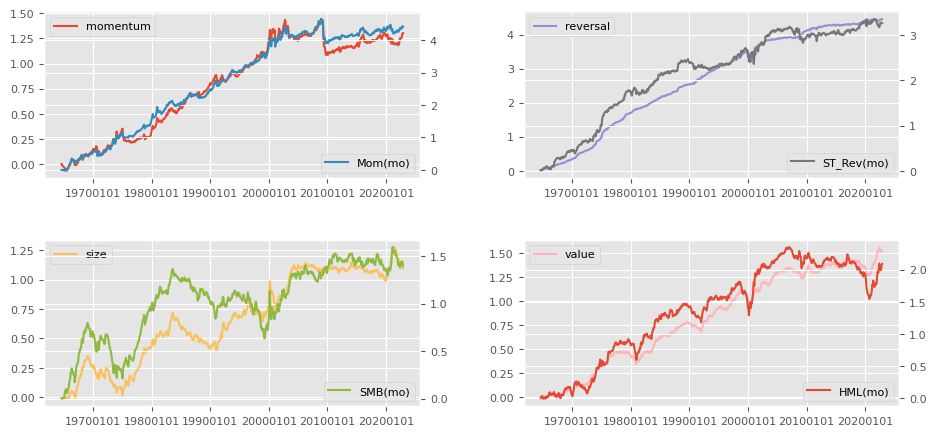

In [9]:
rebalbeg=19640601
rebalend=LAST_DATE
rebaldates = crsp.bd.date_range(rebalbeg, rebalend, 'endmo')
loadings = dict()
for pordate in tqdm(rebaldates):           # retrieve signal values every month
    date = bd.june_universe(pordate)
    univ = crsp.get_universe(date)
    cap = np.sqrt(crsp.get_cap(date))
    smb = -np.log(cap).rename('size')
    hml = signals('hml', date, bd.endmo(date, -12))['hml'].rename('value')
    #beta = signals('beta', pordate, bd.begmo(pordate))['beta']*2/3 + 1/3 #shrink
    mom = signals('mom', pordate)['mom'].rename('momentum')
    strev = -signals('strev', pordate)['strev'].rename('reversal')
    df = pd.concat((strev, hml, smb, mom),  # inner join of signals with univ
                   join='inner',
                   axis=1).reindex(univ.index).dropna()
    loadings[pordate] = winsorize(df, quantiles=[0.05, 0.95])

# Compute coefficients from FM cross-sectional regressions
riskpremium = RiskPremium(user, bench, 'RF', LAST_DATE)
out = riskpremium(stocks=crsp,        # FM regressions on standardized scores
                  loadings=loadings,
                  standardize=['value' ,'size', 'momentum', 'reversal'])
     
# Compare time series of estimated risk premiums to portfolio-sort benchmark eturns
benchnames = {'momentum': 'Mom(mo)',
              'reversal': 'ST_Rev(mo)',
              'size':'SMB(mo)',
              'value': 'HML(mo)'}
out = riskpremium.fit(benchnames.values())  # to compare portfolio-sorts
riskpremium.plot(benchnames)
plt.savefig(imgdir / 'fm.jpg')

In [10]:
# Summarize time-series means of Fama-Macbeth risk premiums
caption, df = ["Fama-MacBeth Cross-sectional Regression Risk Premiums", out[0]]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
show(df, caption=caption)

Factor Returns,mean,stderr,std,count,tvalue,sharpe
Fama-MacBeth Cross-sectional Regression Risk Premiums,,,,,,
reversal,0.0063,0.0005,0.0143,701,11.7877,1.5423
value,0.0022,0.0004,0.0112,701,5.1258,0.6706
size,0.0016,0.0007,0.0175,701,2.3589,0.3086
momentum,0.0019,0.0007,0.0175,701,2.8051,0.3670


In [11]:
# Summarize time-series means of Fama-French portfolio-sort returns
caption, df = ["Fama-French Portfolio-Sorts", out[2]]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
show(df, caption=caption)



Benchmarks,mean,stderr,std,count,tvalue,sharpe
Fama-French Portfolio-Sorts,,,,,,
Mom(mo),0.0063,0.0016,0.0422,701,3.9535,0.5173
ST_Rev(mo),0.0047,0.0012,0.0315,701,3.9134,0.5120
SMB(mo),0.0020,0.0012,0.0307,701,1.7260,0.2258
HML(mo),0.0030,0.0011,0.0299,701,2.6371,0.3450


In [12]:
# Show correlation of returns
df = pd.concat([out[1].join(out[4]), out[4].T.join(out[3])], axis=0)
show(df, 
     caption='Correlation of FM Risk Premiums and FF Portfolio-Sort Returns')

,reversal,value,size,momentum,Mom(mo),ST_Rev(mo),SMB(mo),HML(mo)
Correlation of FM Risk Premiums and FF Portfolio-Sort Returns,,,,,,,,
reversal,1.0000,-0.0039,0.0881,-0.4460,-0.3965,0.7942,0.1340,0.0551
value,-0.0039,1.0000,-0.1993,-0.1860,-0.1618,-0.0399,-0.2487,0.8178
size,0.0881,-0.1993,1.0000,-0.0179,0.1198,0.0176,0.5747,-0.1421
momentum,-0.4460,-0.1860,-0.0179,1.0000,0.8860,-0.2729,-0.0416,-0.2076
Mom(mo),-0.3965,-0.1618,0.1198,0.8860,1.0000,-0.3057,-0.0282,-0.2053
ST_Rev(mo),0.7942,-0.0399,0.0176,-0.2729,-0.3057,1.0000,0.1754,0.0206
SMB(mo),0.1340,-0.2487,0.5747,-0.0416,-0.0282,0.1754,1.0000,-0.1750
HML(mo),0.0551,0.8178,-0.1421,-0.2076,-0.2053,0.0206,-0.1750,1.0000
